# Variables

In [1]:
%load_ext autoreload
%autoreload 2
import latenta as la
import scanpy as sc

In the essentials tutorials, we will primarily work with a small but nontheless interesting single-cell transcriptomics dataset:

In [2]:
adata = la.data.load_myod1()

In [3]:
import numpy as np

sc.pp.normalize_per_cell(adata)
sc.pp.log1p(adata)

sc.pp.combat(adata)
sc.pp.pca(adata)

sc.pp.neighbors(adata)
sc.tl.umap(adata)

adata.obs["log_overexpression"] = np.log1p(adata.obs["overexpression"])

/home/wsaelens/projects/probabilistic-cell/.venv/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'dissociation' as categorical


/home/wsaelens/projects/probabilistic-cell/.venv/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'gene_overexpressed' as categorical


/home/wsaelens/projects/probabilistic-cell/.venv/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'batch' as categorical


/home/wsaelens/projects/probabilistic-cell/.venv/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'biotype' as categorical


/home/wsaelens/projects/probabilistic-cell/.venv/lib/python3.8/site-packages/scanpy/preprocessing/_combat.py:340: RuntimeWarning: divide by zero encountered in true_divide
  (abs(g_new - g_old) / g_old).max(), (abs(d_new - d_old) / d_old).max()


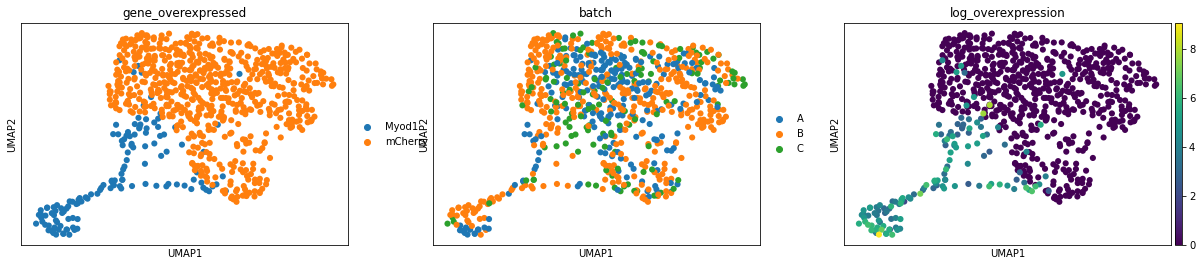

In [4]:
sc.pl.umap(adata, color=["gene_overexpressed", "batch", "log_overexpression"])

In this data, we have overexpressed the transcription factor *Myod1* or a control (mCherry) in a stem cell line across different batches.

As output, we get:
* the transcriptome
* what is overexpressed (*gene overexpressed*)
* the level of overexpression (*log_overexpression*)

## General definition of a variable

A variable in latenta is a representation of a tensor, meaning it is a set of numbers that live in zero (scalar), one (vector), two (matrix), or more dimensions. Each dimension of a variable has coordinates (`.coords`) and identifier (`.id`). Furthermore, a dimension can also be annotated with a label, symbol, and/or description.

Let's start with the prototypical variable, a count matrix, which contains the raw genes expressions in all the cells.

To define its structure, we will first need to define its two dimensions: *genes* and *cells*.
The *genes*, for example, can be defined as follow:

In [5]:
genes = la.Dim(adata.var.index, name="gene")
genes

Dim gene

We can also only provide a pandas series/index, although we have to take care to set the `index.name` beforehand:

In [6]:
adata.var.index.name = "gene"
genes = la.Dim(adata.var.index)
genes

Dim gene

Similarly, for *cells*:

In [7]:
adata.obs.index.name = "cell"
cells = la.Dim(adata.obs.index, name="cell")
cells

Dim cell

Now that we have the two dimensions `genes` and `cells`, we can define how the structure of a count matrix should look like using {class}`la.Definition()`:

In [8]:
counts_definition = la.Definition([cells, genes], "counts")
counts_definition

counts: Definition [cell (799), gene (2047)]

## 1. Fixed variables

Fixed variables contain a tensor with values that never change.

Count matrix is an excellent example of a fixed variable. Let's initialise the variable `counts` containing the raw counts of our data using `la.Fixed()` and by specifying its structure with `counts_definition`:

In [9]:
counts = la.Fixed(adata.X, definition=counts_definition)

You can _run_ a variable by calling it's run function, in that case it will set its value.

In [10]:
counts.run()

The value can now be accessed and because we're working with torch, this value is a `torch.tensor`:

In [11]:
counts.value

tensor([[ 3.3665e+00,  8.3920e-02,  6.2101e-01,  ...,  9.8500e-03,
          9.6566e-03,  2.8354e-02],
        [ 3.2421e+00, -2.8926e-02,  1.3100e-01,  ..., -3.1189e-03,
         -3.9272e-03, -1.6341e-02],
        [ 4.3922e+00, -5.8078e-02,  5.9200e-01,  ..., -3.2546e-03,
         -5.0767e-03, -1.3175e-02],
        ...,
        [ 6.6156e-01,  5.5089e-01,  1.9996e+00,  ..., -3.1189e-03,
         -3.9272e-03, -1.6341e-02],
        [ 3.7754e-03,  9.3089e-01,  1.2229e+00,  ..., -3.1189e-03,
         -3.9272e-03, -1.6341e-02],
        [ 7.7236e-01, -2.8926e-02,  2.1989e+00,  ..., -3.1189e-03,
         -3.9272e-03, -1.6341e-02]])

Because our variable is annotated, we can also get this same value (these same values?) as a dataframe:

In [12]:
counts.value_pd.head()

gene,ENSMUSG00000000031,ENSMUSG00000000058,ENSMUSG00000000078,ENSMUSG00000000184,ENSMUSG00000000202,ENSMUSG00000000247,ENSMUSG00000000486,ENSMUSG00000000489,ENSMUSG00000000555,ENSMUSG00000000567,...,ENSMUSG00000115801,ENSMUSG00000116097,ENSMUSG00000116226,ENSMUSG00000116287,ENSMUSG00000116733,ENSMUSG00000117278,ENSMUSG00000117515,ENSMUSG00000117710,ENSMUSG00000118106,ENSMUSG00000118365
cell,,,,,,,,,,,,,,,,,,,,,
AAAGATGAGGCAATTA-1-5,3.366529,0.083920,0.621007,0.401507,0.029294,0.015265,0.021296,0.018616,0.692346,0.175859,...,0.039710,0.007747,0.018680,0.003235,0.013047,0.007835,-0.016735,0.009850,0.009657,0.028354
AAATGGAGTACGTACT-1-7,3.242099,-0.028926,0.131003,0.511935,0.939495,-0.002911,-0.008375,0.213077,-0.091554,0.800852,...,0.006627,-0.008201,-0.008495,-0.002689,-0.003129,-0.001689,0.459602,-0.003119,-0.003927,-0.016341
AAGACTCTCCGCACTT-1-9,4.392151,-0.058078,0.591996,-0.035182,0.178822,-0.010825,-0.009041,0.435921,0.157620,0.434834,...,0.731178,-0.007789,-0.011596,0.012630,-0.005546,-0.005613,0.037909,-0.003255,-0.005077,-0.013175
AAGGTAATCCTATTTG-1-8,3.063940,0.247491,1.859189,1.257055,-0.004892,-0.002911,-0.008375,-0.013225,0.238253,0.803076,...,0.006627,-0.008201,-0.008495,-0.002689,-0.003129,-0.001689,0.024088,-0.003119,-0.003927,-0.016341
AATCGACTCGTTCTGC-1-7,3.216493,-0.028926,-0.090681,0.372135,1.766135,-0.002911,-0.008375,-0.013225,-0.091554,0.825823,...,0.006627,-0.008201,-0.008495,0.577340,-0.003129,-0.001689,0.024088,-0.003119,-0.003927,-0.016341


Do note that we can also provide pandas and xarray objects to {class}`latenta.variables.Fixed`, and the definition of a variable (its dimensional structure) will be inferred from the object's indices (if we gave them proper names).

Let's try with the level of overexpression in our data:

In [13]:
adata.obs["log_overexpression"]

cell
AAAGATGAGGCAATTA-1-5    6.028279
AAATGGAGTACGTACT-1-7    4.276666
AAGACTCTCCGCACTT-1-9    5.902633
AAGGTAATCCTATTTG-1-8    2.772589
AATCGACTCGTTCTGC-1-7    4.442651
                          ...   
TTTATGCCATACGCTA-1-5    0.000000
TTTCACATCCGGGACT-1-7    0.000000
TTTGATCAGATGCAGC-1-8    0.000000
TTTGATCAGCGATCGA-1-8    0.000000
TTTGGAGAGATTGATG-1-8    0.000000
Name: log_overexpression, Length: 799, dtype: float64

In [14]:
overexpression = la.Fixed(adata.obs["log_overexpression"], label="overexpression")
overexpression

overexpression:  ↦ Fixed [cell (799)]

As we can see, we did not provide a definition to this variable, but it is inferred from the series you provided based on the index name (`adata.obs["log_overexpression"].index.name`). The first dimensions of both our `counts` [cells, genes] and `overexpression` [cells] are therefore equal:

In [15]:
counts[0] == overexpression[0]

True

For discrete fixed variables, we often like to work in a "one-hot" encoding, meaning that we get a binary (True/False or 1/0) matrix if a sample (cell) is part of a particular group (cluster). We can use `la.variables.DiscreteFixed()` to do this conversion by providing a categorical pandas series. In our data, an example of a discrete fixed variable would be a variable indicating what (*Myod1* or control mCherry) is overexpressed in each cell:

```{margin}
A pandas categorical series is equivalent to R's factor
```

In [16]:
adata.obs["gene_overexpressed"]

cell
AAAGATGAGGCAATTA-1-5      Myod1
AAATGGAGTACGTACT-1-7      Myod1
AAGACTCTCCGCACTT-1-9      Myod1
AAGGTAATCCTATTTG-1-8      Myod1
AATCGACTCGTTCTGC-1-7      Myod1
                         ...   
TTTATGCCATACGCTA-1-5    mCherry
TTTCACATCCGGGACT-1-7    mCherry
TTTGATCAGATGCAGC-1-8    mCherry
TTTGATCAGCGATCGA-1-8    mCherry
TTTGGAGAGATTGATG-1-8    mCherry
Name: gene_overexpressed, Length: 799, dtype: category
Categories (2, object): ['Myod1', 'mCherry']

Let's convert it to a discrete fixed variable called `overexpressed` using `la.variables.DiscreteFixed`

In [17]:
overexpressed = la.variables.DiscreteFixed(adata.obs["gene_overexpressed"])
overexpressed

gene_overexpressed:  ↦ DiscreteFixed [cell (799), gene_overexpressed (2)]

In [18]:
overexpressed.run()
overexpressed.value_pd.head()

gene_overexpressed,Myod1,mCherry
cell,,
AAAGATGAGGCAATTA-1-5,1.0,0.0
AAATGGAGTACGTACT-1-7,1.0,0.0
AAGACTCTCCGCACTT-1-9,1.0,0.0
AAGGTAATCCTATTTG-1-8,1.0,0.0
AATCGACTCGTTCTGC-1-7,1.0,0.0


## 2. Parameters

Parameters are unknown variables that have to be inferred (optimized) based on our data. They require a starting default value. A typical example is the slope, basically the log fold-change, of the genes, which is then used to model the transcriptome. We will address/discuss this in more detail just after but let's first define the parameter `slope`:

In [19]:
slope = la.Parameter(
    0.0, definition=la.Definition([genes]), label="slope", symbol=r"\delta"
)
slope

slope:  ↦ Parameter [gene (2047)]

Although parameters are _free_, not fixed, they can still have constraints. For example, the average expression of a gene can never go below zero, as this would be non-sensical. However, most algorithms cannot directly cope with these constraints and prefer to work with parameters that can go from $-\infty$ to $+\infty$ (especially if you also want flexibility). We can solve this by transforming each parameter to make sure they fit our constraints.

Frequently used transformations are:

Description | Support | Transform | Formula
--- | --- | --- | ----
All positive numbers | $R^+$ | `.Exp()` | $e^x$
Unit interval | $[0, 1]$ | `.Logistic()` | $\frac{1}{1+e^{-x}}$
Circular (i.e. an angle) | $[0, 2\pi[$ | `.Circular()` | $ atan2(y, x) $
Simplex | $\in [0, 1] \wedge \sum = 1$ | `.Softmax()` | $\frac{e^{x_i}}{\sum_i e^{x_i}}$

More concretely, we can define a parameter `baseline`, which is the baseline expression of the genes. As just mentioned, it would not make sense to have a negative baseline expression, so we specify to `la.Parameter` using the argument transforms that we want to apply an exponential transformation `la.transforms.Exp`:

In [20]:
baseline = la.Parameter(
    1.0,
    definition=la.Definition([genes]),
    label="baseline",
    transforms=[la.transforms.Exp()],
)
baseline

baseline:  ↦ Parameter [gene (2047)]

A combination of fixed and parameter variables form the leaves of our model. Any other types of variables in our models are ultimately constructed from these leaf variables.

## 3. Computed variables

The variables are used to compute unknown information about our data or to be able to generalise certain results to any future cells. In this case, we create a variable that will depend on other variables, called components. Most of the time, this is done thanks to a regression model and its corresponding link function to modify the input data (see part 2. of the tutorial).

Let's take the example of the gene expression which we need to model. In our data for example, we are interested in how the overexpression of *Myod1* (`overexpression`) will affect the gene expression (compare to control, cells overexpressing mCherry) by a certain factor (`slope`) that will be specific to each gene.

findfont: Font family ['xkcd', 'xkcd Script', 'Humor Sans', 'Comic Neue', 'Comic Sans MS'] not found. Falling back to DejaVu Sans.


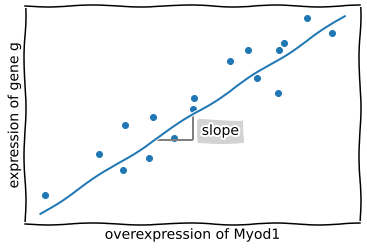

In [21]:
import matplotlib.pyplot as plt

with plt.xkcd():
    np.random.seed(1234)
    x = np.random.uniform(0, 2, 18)
    y = x + np.random.uniform(-0.4, 0.4, 18)
    plt.scatter(x, y)
    plt.plot(np.linspace(0, 2, 9), np.linspace(0, 2, 9))
    plt.hlines(0.75, 0.75, 1, colors="gray")
    plt.vlines(1, 0.75, 1, colors="gray")
    plt.text(x=1.06, y=0.80, s="slope", backgroundcolor="lightgray")
    plt.ylabel("expression of gene g")
    plt.xlabel("overexpression of Myod1")
    ax = plt.gca()
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])
    plt.show()

How much each gene is expressed in each specific cell will then depend on how much it overexpresses *Myod1*.

We end up with the formula:
`expression`$_{g,c}$ ~ `slope`$_{g}$*`overexpression`$_{c}$ for a gene $g$ and a cell $c$

The function `la.links.scalar.Linear` will directly model this for us:

In [22]:
expression = la.links.scalar.Linear(x=overexpression, a=slope, label="expression")
expression

expression: x, a ↦ Linear [cell (•), gene (•)] = $\delta \cdot \mathregular{ overexpression }\require{action}$

The two dimensions of this variable are **broadcasted**, i.e. their coordinates and size are set by upstream components (signified by a •).

The actual definition of the variable can be obtained using `.value_definition`:

In [23]:
expression.value_definition

??: Definition [cell (799), gene (2047)]

When building models, and especially complex models, it gets  really handy to see how the different variables are related in a graph structure:

In [24]:
expression.plot()

:::{seealso}
Visualization and introspection of models is further discussed in the [guide](/guide/introspect)
:::

Components can be accessed using python’s dot notation:

In [25]:
expression.a

slope:  ↦ Parameter [gene (2047)]

Often, components can still be added or changed after the initialisation of a variable. For example, we can now add an intercept (`baseline` defined earlier) to `expression` such that `expression`$_{g,c}$ ~ `slope`$_{g}$*`overexpression`$_{c}$ + `baseline`$_{g}$

In [26]:
expression.a

slope:  ↦ Parameter [gene (2047)]

In [27]:
expression.b = baseline

In [28]:
expression.plot()

Frequently occuring component names are:

Name | Component | Symbol | Description
--- | --- | --- | ----
Input | `.x` | $x$ | What you put into a computed variable
Coefficients, weight, slope | `.a` | $a$ | How much an input affects the output
Intercept,  bias | `.b` | $b$ | The baseline value of the output
Skew, rate | `.skew`, `.rate` | $\gamma$ or $\lambda$ | Scales the input
Shift | `.shift` | $\zeta$ | Shifts the input


## 4. Modular

Sometimes, a computed variable can depend on many variables, and it can become handy to be able to link them easily.

For example, for now the gene `expression` is "simply" modeled based on a baseline expression and the overexpression of *Myod1*, however it could also include the batch from which each cell comes from, or the phase of the cell cycle in which the cell is, etc. It would of course be possible to use the function `la.links.scalar.Linear` to compute the expression as a combination of all these variables, but it would be quite convoluted. Thankfully, instead we can use `la.modular`!

Let's try to redefine `expression` as a modular variable, and as we want to use an additive (linear) model we will use `la.modular.Additive`.

In [29]:
expression = la.modular.Additive(definition=[cells, genes], label="expression")

In [30]:
expression

expression:  ↦ Additive [cell (799), gene (2047)] = $0\require{action}$

Now we have our modular variable `expression` to which we will add the different variables to combine in the linear model.
Note that we are not anymore confined to the usual components defined previously, we can add as many as we want.

In [31]:
expression.baseline = baseline
expression.overexpression = la.links.scalar.Linear(overexpression, a=slope)

In [32]:
expression.overexpression

expression_overexpression: x, a ↦ Linear [cell (•), gene (•)] = $\delta \cdot \mathregular{ overexpression }\require{action}$

In [33]:
expression.plot()

We can see that the two arguments of `expression`, `baseline` and `overexpression`, were automatically combined. Imagine we want to add the batch effect for example, it would be really easy to do so by adding a new argument.

## 5. Distributions

We are often uncertain about the exact value of some variables. For example, for a certain cell and gene we might found that the `expression` value is 4, but we also know that data are noisy and we can therefore not be completly sure that the expression value is exaclty 4, we rather think that it can be somwhere around 4. To model this uncertainty we would use a distribution.

<!--This doesn't help my own comprehension, I would leave it out, but ofc everyone has his own way of understanding so it might be usefull for others, I let you choose :) -->
There are two ways to define/initialize a distribution:
- We can take a random sample. For example, let's imagine a simple (non-biological) example, we have a die, we roll it and get 3.
- We have some information and we can calculate the probability of a particular sample, also known as the likelihood. For example, for a fair die the probability of observing a 3 is 1/6.

<!--This is also not very very clear, I remember you explained to me and it did make sense however here without example to showcase I would not adress that (yet at leaast)-->    
Depending on the distribution, individual elements of a sample can be dependent. Furthermore, this dependence can be specific to particular dimensions. For example, if we would sample from a OneHotCategorical distribution, there can only be one 1 in every row.

Let's continue on the gene expression example. We previously defined the computed variable `expression`, however as we just mentionned we cannot be certain that the expression will be these exact values, but it will rather range around this value. A distribution we typically use for gene expression is a negative binomial, and more specifically the `NegativeBinomial2` variant that has two input parameters: the average count (`.mu`) and the dispersion (`.dispersion`). (Note that we denote the fact that it is a distribution variable with _p)

```{margin}
The naming conventions used are those from ProbOnto (https://sites.google.com/site/probonto/home) whenever available.
```

In [34]:
transcriptome_p = la.distributions.NegativeBinomial2(mu=expression)

Note that most commonly used distributions have an _average_, also called a location, loc, mu or mean, and also an _uncertainty_, also called the standard deviation, sigma, scale or dispersion. This is also the case for the `NegatobeBinomial2`, for which we did not specify the `dispersion`, and is then by default set to 1.

Running a distribution will pick a certain value from the distribution:

In [35]:
transcriptome_p.run()
transcriptome_p.value_pd.head()

gene,ENSMUSG00000000031,ENSMUSG00000000058,ENSMUSG00000000078,ENSMUSG00000000184,ENSMUSG00000000202,ENSMUSG00000000247,ENSMUSG00000000486,ENSMUSG00000000489,ENSMUSG00000000555,ENSMUSG00000000567,...,ENSMUSG00000115801,ENSMUSG00000116097,ENSMUSG00000116226,ENSMUSG00000116287,ENSMUSG00000116733,ENSMUSG00000117278,ENSMUSG00000117515,ENSMUSG00000117710,ENSMUSG00000118106,ENSMUSG00000118365
cell,,,,,,,,,,,,,,,,,,,,,
AAAGATGAGGCAATTA-1-5,1.0,1.0,2.0,1.0,3.0,2.0,1.0,0.0,4.0,1.0,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
AAATGGAGTACGTACT-1-7,1.0,2.0,0.0,2.0,0.0,0.0,3.0,3.0,0.0,1.0,...,5.0,2.0,2.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0
AAGACTCTCCGCACTT-1-9,1.0,1.0,2.0,1.0,1.0,0.0,2.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0
AAGGTAATCCTATTTG-1-8,0.0,1.0,0.0,1.0,0.0,2.0,2.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0,0.0
AATCGACTCGTTCTGC-1-7,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,3.0,3.0,1.0,1.0,1.0,0.0,5.0,0.0,0.0


Because we model an observation as a distribution, we can calculate how likely this observation is according to this distribution. The goal of any modelling is to maximize this likelihood, while remaining within the constraints imposed by the model.

In [36]:
transcriptome_p.likelihood

tensor([[-1.3863, -1.3863, -2.0794,  ..., -0.6931, -1.3863, -1.3863],
        [-1.3863, -2.0794, -0.6931,  ..., -0.6931, -1.3863, -2.0794],
        [-1.3863, -1.3863, -2.0794,  ..., -2.0794, -0.6931, -0.6931],
        ...,
        [-2.0794, -0.6931, -0.6931,  ..., -0.6931, -0.6931, -1.3863],
        [-1.3863, -1.3863, -0.6931,  ..., -0.6931, -2.7726, -1.3863],
        [-2.0794, -0.6931, -0.6931,  ..., -2.7726, -0.6931, -0.6931]],
       grad_fn=<SubBackward0>)

Distributions often have the following components:

Name | Component | Symbol | Description
--- | --- | --- | ----
Location | `.loc` | $\mu$ | The mean, changing this parameter simply shifts the probability function
Mean | `.mu` | $\mu$ | The mean, in case it is not a location parameter
Scale | `.scale` | $\sigma$ | Measure of variability, changing this parameter simply scales the probability function
Dispersion | `.dispersion` | $\theta$ | Measure of variability, in case it is not a scale parameter
Probability | `.probs` | $p$ | A probability of success
Total counts | `.total_counts` | $n$ | Number of tries

## 6. Observations

Observations are fixed variables that follow a distribution. An observation always has some physical connection to reality, but the problem is that we only observe a noisy variant of this reality. This noise is not always purely technical (due to stochastic sampling of mRNAs) but also typically contains biological components (such as transcriptional bursting). Essentially, any variation that the model cannot explain is explained away as noise. In our case, this noise is in the dispersion component of the Negative Binomial.

In [37]:
transcriptome = la.Observation(
    value=counts.value, p=transcriptome_p, definition=counts_definition
)

transcriptome.plot()

Running an observation does the same thing as running a fixed variable, meaning it sets its values.

In [38]:
transcriptome.run()

Because we model an observation as a distribution, we can calculate how likely this observation is according to this distribution. The goal of modelling is to maximize this likelihood, while remaining within the constraints imposed by the model.

In [39]:
transcriptome.likelihood

tensor([[-3.0266, -0.7513, -1.1236,  ..., -0.7000, -0.6998, -0.7128],
        [-2.9404, -0.6731, -0.7840,  ..., -0.6910, -0.6904, -0.6818],
        [-3.7376, -0.6529, -1.1035,  ..., -0.6909, -0.6896, -0.6840],
        ...,
        [-1.1517, -1.0750, -2.0792,  ..., -0.6910, -0.6904, -0.6818],
        [-0.6958, -1.3384, -1.5408,  ..., -0.6910, -0.6904, -0.6818],
        [-1.2285, -0.6731, -2.2173,  ..., -0.6910, -0.6904, -0.6818]],
       grad_fn=<SubBackward0>)

## 7. Latent

Latent variables are, by definition, variables we believe exist but are not directly observable through experimentation. They are therefore unknown variables which the model needs to estimate, and contrary to parameters which also need to be estimated and have one fixed value, latent variables follow a distribution. Latent variables are central to probabilistic modelling, because they encompass two types of uncertainty:

::::{margin}
:::{seealso}
https://en.wikipedia.org/wiki/Uncertainty_quantification#Aleatoric_and_epistemic_uncertainty
:::
::::

### 1. Uncertainty inherent to the system
::::{margin}
:::{note}
In general, we call this _aleatoric uncertainty_. In bayesian modelling, this type of uncertainty is typically encoded as the prior distribution.
:::
::::

Let's say we are randomly sampling a cell from a tissue. Every time we take such a sample, we do not know what type of cell it will be, except perhaps that some cell types are more likely to be picked because they are more abundant. This uncertainty is inherent to the population, and nothing we do can change that. We model this uncertainty as an appropriate probability distribution, which can have some known or unknown components.

This type of uncertainty is often of interest and can provide interesting biological information in more complex models.

For example:
- How does cell type abundance change across different conditions?
- What is the distribution of all cell's pseudotime? Are there more early than late cells? Does this change between conditions?
- What is the distribution of the gene's fold changes? Are there more upregulated than downregulated genes? Are there a couple of genes with massive changes, while all other genes do not change at all?
- What is the effect of a transcription factor (like *Myod1" in our example)? Does it have many target genes with a subtle effect? Or a few target genes but with a very strong effect?

### 2. Uncertainty because of lack of data

::::{margin}
:::{note}
In general, we call this _epistemic uncertainty_. In bayesian modelling, this type of uncertainty is typically encoded as the posterior.
:::
::::
Let's say we focus on one particular cell, and we want to know its cell type. Naturally, before we observe anything about this cell, our uncertainty is the same as that inherent to the system (as described above). However, if we now observe some gene expression, our uncertainty for this particular cell decreases. The more genes we observe, the more certain we will become.

This type of uncertainty is not inherent to the cell. The cell does not change its cell type just because we are uncertain about it. Therefore it does not have a direct connection to reality but is simply an artefact of us not knowing enough. Nonetheless, modelling this uncertainty is crucial because it gives us an idea about how certain we are about a variable. For example:
- We may be very sure about a cell's cell type but be very uncertain about the cellular state. This could tell us that we do not have enough sequencing depth to assign a cell's state.
- If a gene's fold-change has a distribution spreading over both negative and positive we might not have enough data. This does not necessarily mean that the gene is not differentially expressed, but rather that we do not have enough data to know whether it is.
- It may be that two transcription factors can equally regulate gene expression in the model and that we do not have enough data to say which one is more likely.

### Constructing a latent variable

Latent variables combine both types of uncertainty:

Name | Component | Symbol | Description
--- | --- | --- | ----
Prior distribution | `.p` | $p$ | The distribution followed by the variable, inherent to the system. Note that this distribution can depend on other parameters, latent or fixed variables.
Variational distribution | `.q` | $q$ | An approximation of the posterior distribution, i.e. the distribution followed by a variable after observing the data. The parameters of this distribution can be estimated directly (i.e. as one or more Parameter) or through the observed data using amortization

A prototypical example of a latent variable is the slope (i.e. fold-change) in a linear model.
We indeed want to put some constraints on the fold-changes of genes. It is a reasonable assumption that most gene will not be very affected by the overexpression of *Myod1*. Therefore, we want to add some "prior" knowledge/constraints to not allow the model to find/fit enormous fold-changes, except if the data provides strong evidence that it is indeed the case (we will discuss further in the regression part). Let's now redefine the slope as a latent variable:

In [40]:
slope_p = la.distributions.Normal(
    loc=0.0, scale=la.Parameter(1.0, transforms=[la.transforms.Exp()])
)
latent_slope = la.Latent(p=slope_p, definition=la.Definition([genes]), label="slope")
latent_slope.plot()

The prior distribution $p$, in this case, is a normal distribution centered in 0 with one free parameter: the scale $\sigma$. This parameter determines how far the slope _on average_ can be different from 0. We can estimate this as a parameter only because we are pooling information across many genes. This kind of {term}`multi-level modelling` is very powerful, as it includes multiple testing correction directly within the model {citel}`gelman_why_2009`.

The variational distribution $q$, on the other hand, contains two parameters specific for each gene. These contain our idea of where the slope of a gene will lie: the location $\mu$ is the average, while the scale $\sigma$ our uncertainty.

We can now modify the slope (`.a`) of the computed variable `expression` with a latent variable rather than a parameter.

In [41]:
expression.a = latent_slope
expression.plot()

Note that many link functions will create a latent variable automatically if you specify `True` for the coresponding argument, although you have to provide the correct definition if some dimensions cannot be inferred from other components. For example for the `expression` we could have directly done:

In [42]:
expression = la.links.scalar.Linear(
    overexpression,
    a=True,  # 👈
    b=baseline,
    label="expression",
    definition=la.Definition([cells, genes]),  # ⚠️
)
expression.plot()

In [43]:
expression.a.p

p: scale, loc ↦ Normal [gene (2047)]

:::{note}
Sometimes components of the prior distribution may themselves depend on a latent variable. In that case, this distribution will encompass both types of uncertainty. This would be the case for [most examples we gave for prior distributions](#uncertainty-inherent-to-the-system).
:::

Just like parameters, the two distributions of latent variables may also have transformations. This is, for example, the case if we would use a `.LogNormal` as prior, which only takes positive numbers as input. A good example is the baseline expression of the genes:

In [44]:
baseline_p = la.distributions.LogNormal(
    loc=la.Parameter(0.0), scale=la.Parameter(1.0, transforms=[la.transforms.Exp()])
)
latent_baseline = la.Latent(
    p=baseline_p, definition=la.Definition([genes]), label="baseline"
)
latent_baseline.plot()

We can now modify the baseline (`.b`) of expression as a latent variable:

In [45]:
expression.b = latent_baseline
expression.plot()

Should we specify that it doesn't automatically updates the other variables that depends on them?

In [46]:
transcriptome.plot()

## 8. Root

We sometimes want to combine several unrelated variables in a model.

## Main points
- Modelling is creating and connecting variables in a graph structure
- Leaf variables are the start of any model. Different types of leaf variables have different functions:
   - Fixed variables are provided by you or set to a reasonable default value
   - Parameters are free and have to be estimated from the data
   - Observations are fixed variables that follow a distribution
- Computed variables link different variables together in a deterministic way
- Combining several effects is possible using modular variables
- Distributions model uncertainty, and often (but not always) have components that model the mean and variability
- Latent variables are the variables we are the most interested in, as they encompass both the uncertainty inherent to the system and the uncertainty due to the lack of data

Now that we know how variables work, let's look at how we can combine these different variables to model and find optimal values for the free parameters in the next tutorial